In [26]:
from OSCC_postprocessing.dewe.dewe import *
from OSCC_postprocessing.dewe.heat_release_calulation import hrr_calc

file_path = r"G:\MeOH_test\Dewe\T2_0001.dxd"



DWDataReaderLib result:
 - Sample rate: 1000000.000 Hz
 - Duration: 21.300 s
 - Time channel: Chamber gas temperature
 - Channels loaded: 13 (Chamber gas temperature,
 Fuel Pressure,
 Main Injector - Current Profile,
 Intake Pressure (BarA),
 Chamber pressure (BarA),
 Temperature acc. Ideal gas law,
 Heat Release,
 Chamber pressure (BarA)/FIR Filter/Derivative,
 Intake Pressure (BarA)/FIR Filter,
 Fuel Pressure/FIR Filter,
 Chamber gas temperature/FIR Filter,
 Chamber pressure (BarA)/FIR Filter,
 Main Injector - Current Profile/FIR Filter)
 - Async channels (not in DataFrame): Fuel Pressure, Main Injector - Current Profile, Intake Pressure (BarA), Chamber pressure (BarA), Temperature acc. Ideal gas law, Heat Release, ...
 - DataFrame shape: (25000, 13)
 - Columns: ['Chamber gas temperature', 'Fuel Pressure', 'Main Injector - Current Profile', 'Intake Pressure (BarA)', 'Chamber pressure (BarA)', 'Temperature acc. Ideal gas law', 'Heat Release', 'Chamber pressure (BarA)/FIR Filter/Deriva

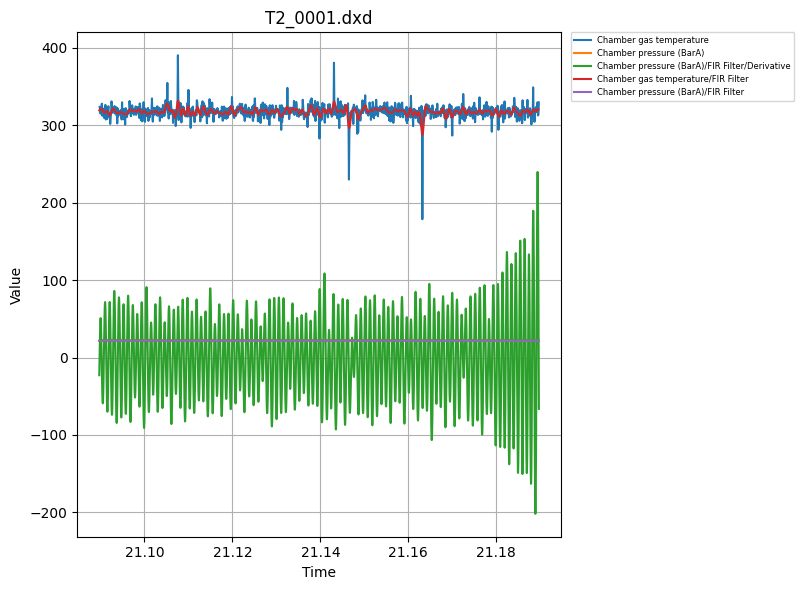

In [27]:

path = resolve_data_path(file_path)
df = load_dataframe(path)

# First pass: create independent figures/axes, don't show yet
_fig1, _ax1 = cast(Tuple[Figure, Axes], plot_dataframe(
    df, title=path.name, 
    criteria=["Chamber Pressure", "Chamber gas temperature"],
    return_fig=True, show=False
))


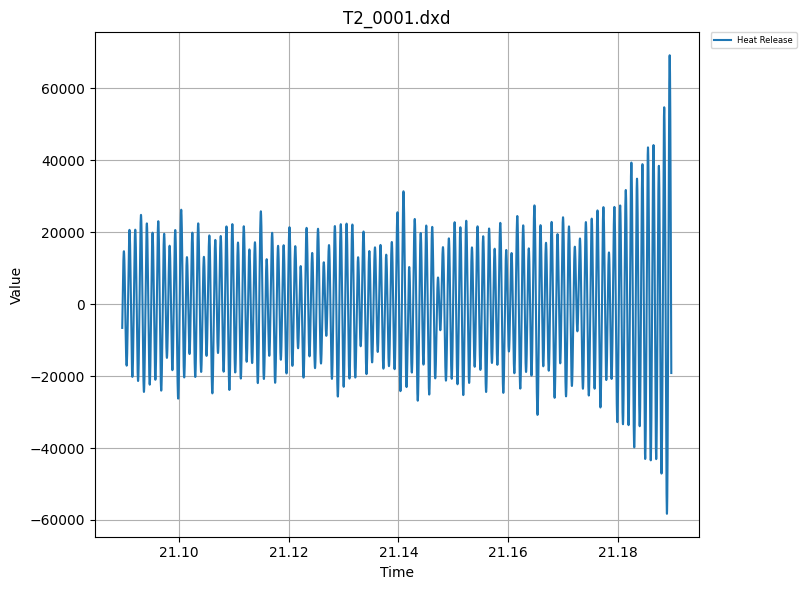

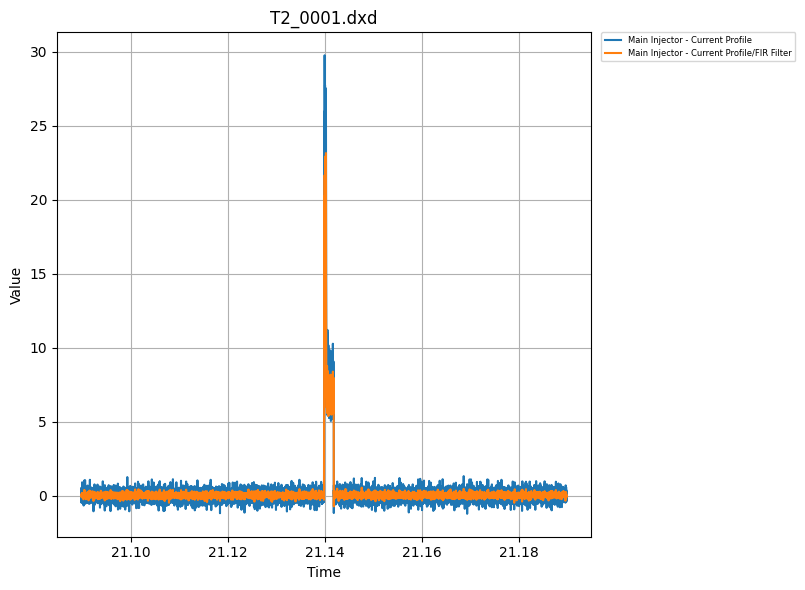

In [28]:


df_heat_release = df[[col for col in df.columns if "Heat Release" in col]].copy()
if "Heat Release" in df_heat_release.columns:
    df_heat_release["Heat Release"] = df_heat_release["Heat Release"] * 100  # scale for visibility


# plot_dataframe(df, criteria=["Heat Release"], ax=_ax1, show=False)
_fig2, _ax2 = cast(Tuple[Figure, Axes], plot_dataframe(
    df_heat_release, title=path.name, 
    criteria=["Heat Release"],
    return_fig=True, show=False
))


_fig3, _ax3 = cast(Tuple[Figure, Axes], plot_dataframe(
    df, title=path.name, 
    criteria=["Current Profile"],
    return_fig=True, show=False
))



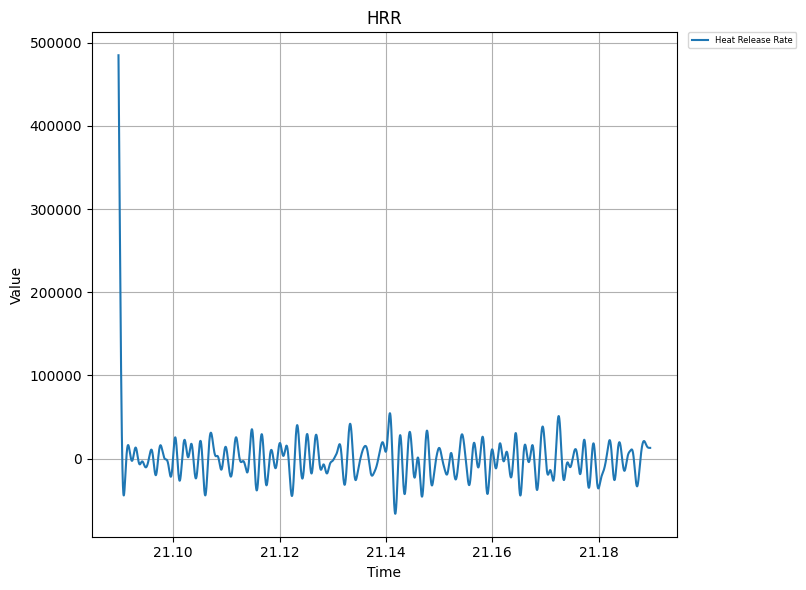

In [29]:


chamber_pressure_col = next((c for c in df.columns if "chamber pressure" in c.lower()), None)

if chamber_pressure_col is None:
    raise RuntimeError("No chamber pressure column found for HRR calculation")

ChmbP_bar = df[chamber_pressure_col].to_numpy()
time_seconds = df.index.to_numpy() if df.index.name == "time_s" else None
df_hrr = hrr_calc(ChmbP_bar, time=time_seconds, V_m3=8.5e-3, gamma=1.35)

# First plot (pressure-derived HRR)
fig4, ax4 = plot_dataframe(
    df_hrr.set_index("time_s").rename(columns={"HRR_W": "Heat Release Rate"}),
    title="HRR",
    criteria=["Heat Release Rate"], return_fig=True
)
plt.show()

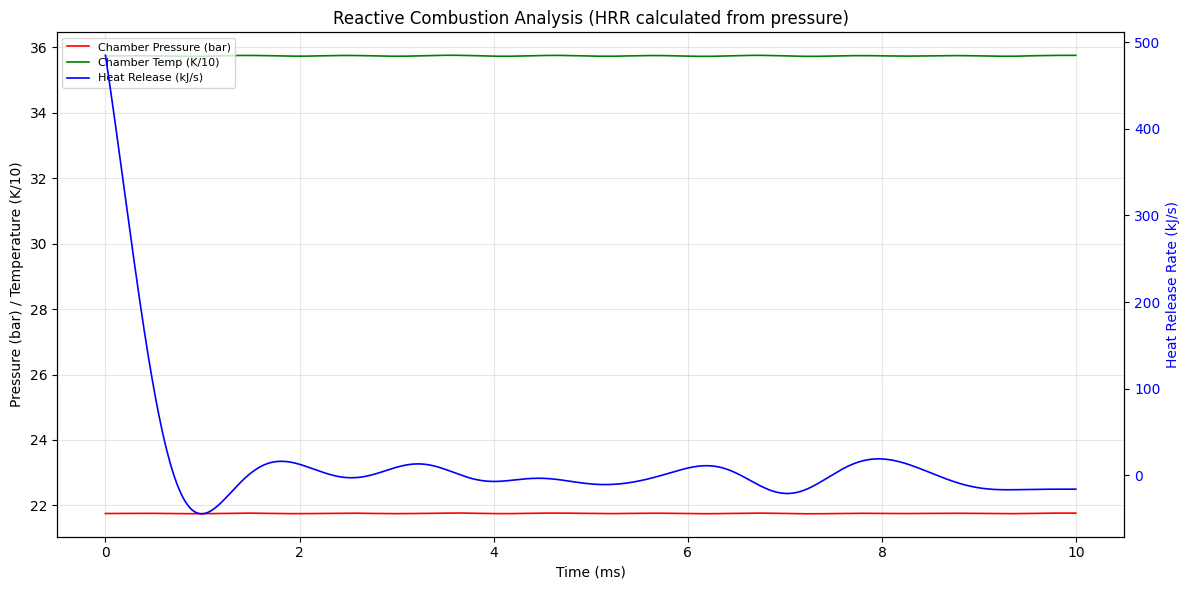

Available columns: ['time_ms', 'Chamber gas temperature', 'Fuel Pressure', 'Main Injector - Current Profile', 'Intake Pressure (BarA)', 'Chamber pressure (BarA)', 'Temperature acc. Ideal gas law', 'Heat Release', 'Chamber pressure (BarA)/FIR Filter/Derivative', 'Intake Pressure (BarA)/FIR Filter', 'Fuel Pressure/FIR Filter', 'Chamber gas temperature/FIR Filter', 'Chamber pressure (BarA)/FIR Filter', 'Main Injector - Current Profile/FIR Filter']


In [30]:
# Plot reactive data with dual Y-axes (matching MATLAB ReactivePlottingFunc logic)
# This plots: Chamber Pressure (red), Temperature (green) on left axis
#             Heat Release Rate (blue) on right axis - CALCULATED from pressure using hrr_calc
#
# The HRR is calculated using the constant-volume formula (matching MATLAB HrrCalc.m):
#     HRR(t) = (V / (gamma - 1)) * dP/dt
# where V = 8.5e-3 m³ (8.5 liters), gamma = 1.35

# Reload module to pick up changes (remove this after first run)
import importlib
import OSCC_postprocessing.dewe.dewe as dewe_module
importlib.reload(dewe_module)

from OSCC_postprocessing.dewe.dewe import plot_reactive, align_dewe_dataframe_to_soe

# Align dataframe to Start of Energization (SoE) - this mirrors the MATLAB alignment logic
df_aligned = align_dewe_dataframe_to_soe(df, window_ms=10.0)

# Plot the reactive data with dual y-axes
# HRR is calculated automatically from chamber pressure - NOT read from dxd file
fig, ax = plot_reactive(
    df_aligned,
    chamber_pressure_col="Chamber pressure (BarA)",  # Adjust column name as needed
    chamber_temperature_col="Temperature acc. Ideal gas law",  # Adjust column name as needed
    time_col="time_ms",
    # HRR calculation parameters (matching MATLAB HrrCalc.m)
    V_m3=8.5e-3,  # Chamber volume in m³ (8.5 liters)
    gamma=1.35,   # Heat capacity ratio
    fc_p=1000.0,  # Butterworth pre-filter cutoff for pressure [Hz]
    fc_hrr=600.0, # Butterworth post-filter cutoff for HRR [Hz]
    smooth=True,
    smoothing_factor=0.2,
    title="Reactive Combustion Analysis (HRR calculated from pressure)",
    figsize=(12, 6),
)
plt.show()

# Print available columns for reference
print("Available columns:", list(df_aligned.columns))

## Reactive Plot (Matching MATLAB ReactivePlottingFunc)

The `plot_reactive` function replicates the MATLAB `ReactivePlottingFunc.m` logic:

**Left Y-axis:**
- Chamber Pressure (bar) - Red
- Chamber Temperature (K/10) - Green

**Right Y-axis:**
- Heat Release Rate (kJ/s) - Blue - **CALCULATED from pressure, not read from dxd**

### HRR Calculation (matching MATLAB HrrCalc.m)

The heat release rate is calculated using the constant-volume formula:

$$HRR(t) = \frac{V}{\gamma - 1} \cdot \frac{dP}{dt}$$

Where:
- `V = 8.5e-3 m³` (8.5 liters chamber volume)
- `γ = 1.35` (heat capacity ratio)
- `dP/dt` = pressure derivative (filtered with Butterworth low-pass)

This ensures the HRR is derived from raw pressure data, matching the MATLAB implementation exactly.

### Features:
- Gaussian smoothing (configurable)
- Support for multiple testpoints with different line styles (-, --, :)
- Butterworth filtering for pressure (fc=1000Hz) and HRR (fc=600Hz)
- Auto-detection of column names

## Multiple Testpoint Comparison

The `plot_reactive` function supports plotting multiple .dxd files in the same figure, with different line styles for each testpoint (matching MATLAB behavior):
- Testpoint 1: Solid line (-)
- Testpoint 2: Dashed line (--)
- Testpoint 3: Dotted line (:)

In [31]:
# Load multiple .dxd files for comparison
from pathlib import Path

# Define testpoints to compare
testpoint_files = [
    r"G:\MeOH_test\Dewe\T2_0001.dxd",
    r"G:\MeOH_test\Dewe\T56_0001.dxd",
]
testpoint_labels = ["T2", "T56"]

# Load and align each file
aligned_dataframes = []
for file_path in testpoint_files:
    path = Path(file_path)
    if path.exists():
        print(f"Loading: {path.name}")
        df_temp = load_dataframe(path)
        df_aligned_temp = align_dewe_dataframe_to_soe(df_temp, window_ms=10.0)
        aligned_dataframes.append(df_aligned_temp)
        print(f"  - Aligned shape: {df_aligned_temp.shape}")
    else:
        print(f"File not found: {file_path}")

print(f"\nLoaded {len(aligned_dataframes)} dataframes for comparison")

Loading: T2_0001.dxd
DWDataReaderLib result:
 - Sample rate: 1000000.000 Hz
 - Duration: 21.300 s
 - Time channel: Chamber gas temperature
 - Channels loaded: 13 (Chamber gas temperature,
 Fuel Pressure,
 Main Injector - Current Profile,
 Intake Pressure (BarA),
 Chamber pressure (BarA),
 Temperature acc. Ideal gas law,
 Heat Release,
 Chamber pressure (BarA)/FIR Filter/Derivative,
 Intake Pressure (BarA)/FIR Filter,
 Fuel Pressure/FIR Filter,
 Chamber gas temperature/FIR Filter,
 Chamber pressure (BarA)/FIR Filter,
 Main Injector - Current Profile/FIR Filter)
 - Async channels (not in DataFrame): Fuel Pressure, Main Injector - Current Profile, Intake Pressure (BarA), Chamber pressure (BarA), Temperature acc. Ideal gas law, Heat Release, ...
 - DataFrame shape: (25000, 13)
 - Columns: ['Chamber gas temperature', 'Fuel Pressure', 'Main Injector - Current Profile', 'Intake Pressure (BarA)', 'Chamber pressure (BarA)', 'Temperature acc. Ideal gas law', 'Heat Release', 'Chamber pressure (Ba

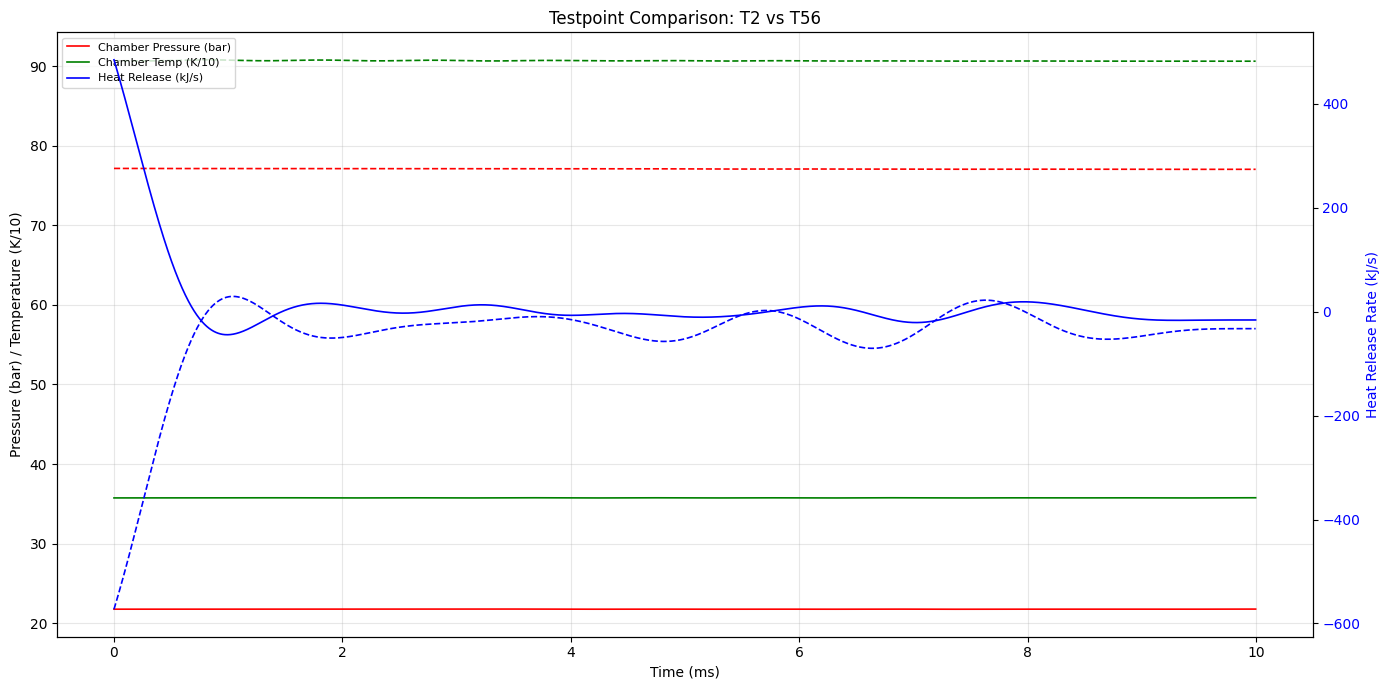

In [32]:
# Plot multiple testpoints on the same figure
# Each testpoint gets a different line style: solid (-), dashed (--), dotted (:)

if len(aligned_dataframes) > 0:
    fig, ax = plot_reactive(
        aligned_dataframes,
        testpoint_labels=testpoint_labels,
        chamber_pressure_col="Chamber pressure (BarA)",
        chamber_temperature_col="Temperature acc. Ideal gas law",
        time_col="time_ms",
        # HRR calculation parameters (matching MATLAB HrrCalc.m)
        V_m3=8.5e-3,   # Chamber volume in m³ (8.5 liters)
        gamma=1.35,    # Heat capacity ratio
        fc_p=1000.0,   # Butterworth pre-filter cutoff for pressure [Hz]
        fc_hrr=600.0,  # Butterworth post-filter cutoff for HRR [Hz]
        smooth=True,
        smoothing_factor=0.2,
        title=f"Testpoint Comparison: {' vs '.join(testpoint_labels)}",
        figsize=(14, 7),
    )
    plt.show()
else:
    print("No dataframes loaded - check file paths")

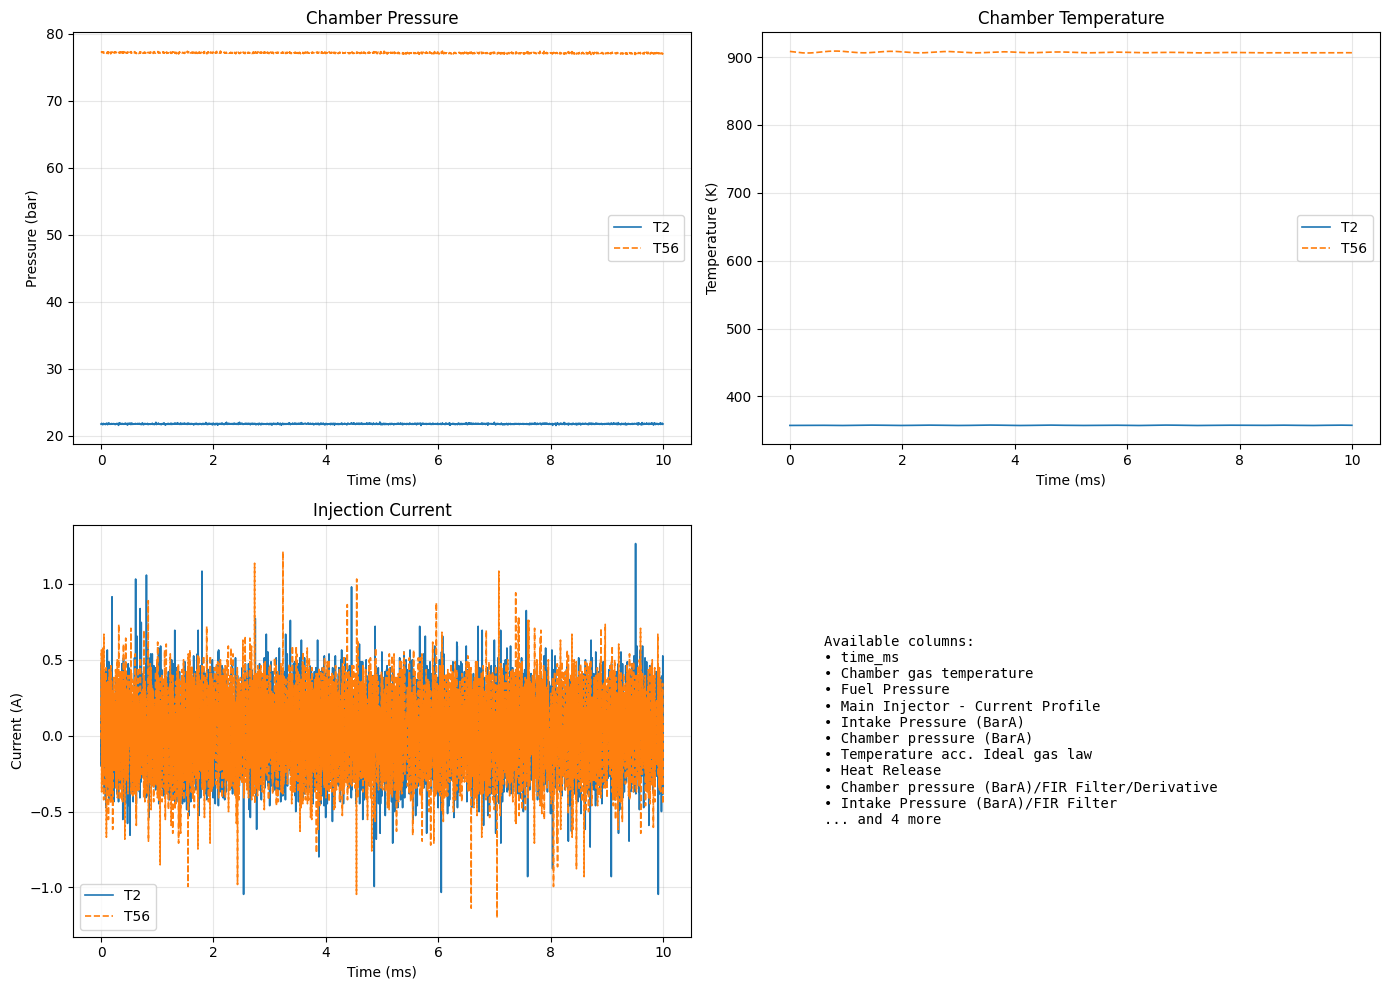

In [33]:
# Compare individual channels between testpoints
if len(aligned_dataframes) >= 2:
    import matplotlib.pyplot as plt
    
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    
    pressure_col = "Chamber pressure (BarA)"
    temp_col = "Temperature acc. Ideal gas law"
    
    for idx, (df_tp, label) in enumerate(zip(aligned_dataframes, testpoint_labels)):
        style = ["-", "--", ":"][idx % 3]
        
        # Pressure comparison
        if pressure_col in df_tp.columns:
            axes[0, 0].plot(df_tp["time_ms"], df_tp[pressure_col], 
                           linestyle=style, label=label, linewidth=1.2)
        
        # Temperature comparison
        if temp_col in df_tp.columns:
            axes[0, 1].plot(df_tp["time_ms"], df_tp[temp_col], 
                           linestyle=style, label=label, linewidth=1.2)
        
        # Injection current comparison
        current_col = "Main Injector - Current Profile"
        if current_col in df_tp.columns:
            axes[1, 0].plot(df_tp["time_ms"], df_tp[current_col], 
                           linestyle=style, label=label, linewidth=1.2)
    
    axes[0, 0].set_title("Chamber Pressure")
    axes[0, 0].set_xlabel("Time (ms)")
    axes[0, 0].set_ylabel("Pressure (bar)")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    axes[0, 1].set_title("Chamber Temperature")
    axes[0, 1].set_xlabel("Time (ms)")
    axes[0, 1].set_ylabel("Temperature (K)")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    axes[1, 0].set_title("Injection Current")
    axes[1, 0].set_xlabel("Time (ms)")
    axes[1, 0].set_ylabel("Current (A)")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Show available columns
    axes[1, 1].axis("off")
    col_text = "Available columns:\n" + "\n".join(f"• {c}" for c in aligned_dataframes[0].columns[:10])
    if len(aligned_dataframes[0].columns) > 10:
        col_text += f"\n... and {len(aligned_dataframes[0].columns) - 10} more"
    axes[1, 1].text(0.1, 0.5, col_text, fontsize=10, verticalalignment="center", 
                    family="monospace", transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()